In [28]:
## Provide a wider display for easier viewing
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
## Import the necessary libraries
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn import *
import seaborn as sns
from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV, StratifiedKFold, KFold
from sklearn.metrics import *
import sklearn
import tensorflow as tf

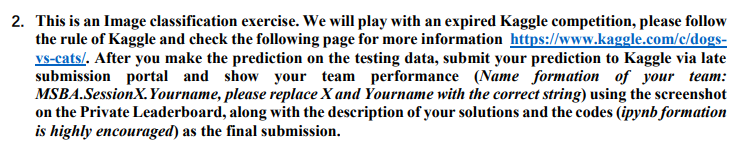

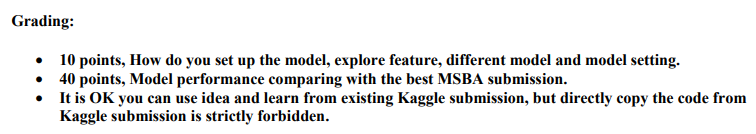

## A.  Image pre-processing and selection

In [4]:
## Import the libraries needed to process our image files

import cv2
import numpy as np
import os, sys

## We want to shuffle our pictures so our models don't overfit

from random import shuffle

In [5]:
## Set the directories needed to load the images

## Set the present working directory
pwd = os.getcwd()

## Directory holding our training images
train_dir = pwd+"\\train"

## Directory holding our testing images
test_dir = pwd+"\\test"

## Setting an image size for the files - I selected 64 since the VM I'm running this on
## doesn't have the capacity for bigger images - the model would likely perform better with a larger image size

img_size = 64

In [6]:
## Create a custom function to label our cat/dog images - this we can use later to differentiate between them

def cat_dog_label_img(image):
    
    ## Take the image file name and look at the last three letters - they are either "cat" or "dog"
    label = image.split(".")[-3]
    
    ## If it's a cat, then return a 1
    if label == "cat": return [1, 0]
    
    ## Else it's going to be a dog so we return a 0
    elif label == "dog": return [0, 1]

In [18]:
## Create another custom function to load the training data - since we have so many images, and to save processing
## time, we can save these files to a folder - excuse the name :)

def generate_train_data():
    
    ## Save all the training information into an empty list
    training_data = []
    
    ## Loop through every image listed in the training file
    for img in os.listdir(train_dir):
        
        ## Label the image using the function we created above
        label = cat_dog_label_img(img)
        
        ## Create a path for every image
        path = os.path.join(train_dir, img)
        
        ## Use the cv2 module to read in the image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE)  ## We use grayscale, but we can also use color
        
        ## Resize the image to a standard image size of 64x64 since they come in different sizes
        img = cv2.resize(img, (img_size, img_size))
        
        ## One step I missed here was dividing by 255 to normalize the image arrays
        
        ## Append each image and its corresponding label to our training data
        training_data.append([np.array(img), np.array(label)])
    
    ## Randomize our training data so that our models don't fall victim to overfitting
    shuffle(training_data)
    
    ## This can be saved to a file to cut down on the processing time required to 
    ## np.save("D:\\Stupid Cat Photos\\train_data.npy", training_data)
    
    return training_data

In [19]:
## Create a batch of training data to start using with our models

training_data = generate_train_data()

## B. Start building the models

In [7]:
## Import all the libraries - pretty much everything from Keras & Tensorflow

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *

Using TensorFlow backend.


## I am going to start by generating a model that uses three convultion layers with single stride, zero padding and relu activation.

## Each layer the filter count is increasing, because our initial layer represents the high level features of image and the deeper layers represent more detailed features (thereby needing a larger number of filters).  That's why we see it start at 32, then build to 50, and the finally 80.

## I am also adding a step to "dropout" 25% of the data - this is what I'll use to help mitigate against overfitting.

In [73]:
## Define the first function that creates a model

def create_dog_cat_image_classifier():
    
    ## First layer

    model = Sequential()

    model.add(InputLayer(input_shape=[64, 64, 1]))

    model.add(Conv2D(filters = 32, kernel_size = 5, strides = 1, padding = "same", activation = "relu"))
    model.add(MaxPool2D(pool_size = 5, padding = "same"))
    
    ## Second layer

    model.add(Conv2D(filters = 50, kernel_size = 5, strides = 1, padding = "same", activation = "relu"))
    model.add(MaxPool2D(pool_size = 5, padding = "same"))
    
    ## Third layer

    model.add(Conv2D(filters = 80, kernel_size = 5, strides = 1, padding = "same", activation = "relu"))
    model.add(MaxPool2D(pool_size = 5, padding = "same"))
    
    ## Add dropout to solve for overfitting

    model.add(Dropout(0.25)) ## 25% of data gets sliced out
    model.add(Flatten())

    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(rate = 0.5))
    
    ## Add layer for our prediction - cats or dogs?

    model.add(Dense(2, activation = "softmax"))
    
    ## Use Adam as our optimizer with a really low learning rate - this can probably be tweaked.
    optimizer = Adam(lr = 0.0001)
    
    ## Bring it all together
    model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
    
    ## Return the completed model
    return model

## After the three convolution layers we have one dropout layer to avoid overfitting.  Once the image passes through the convolution layers it has to be flattened again to be fed into the fully connected layers (dense in Keras).  All the neurons in the first layer connect to all the neurons in the second layer.

## Now that we have images loaded, we'll reshape them into the right format for the model we just created.

In [74]:
## Using the training data, we create the X variable by reshaping the image files into a format that our
## data mining technique will be able to consume.
X = np.array([i[0] for i in training_data]).reshape(-1, 64, 64, 1)

## Our labels are much simpler and don't require the reshaping step.
y = np.array([i[1] for i in training_data])

In [75]:
## Split our data 70-30 to feed through our model - 25000 images is quite a bit
## Random seed of 42 so I can recreate these results if needed.

X_train, X_test, y_train, y_test = train_test_split(X, y, 
                                                    test_size = 0.3, random_state = 42)

In [76]:
## Create our first model using the function that was built above

first_dog_cat_model = create_dog_cat_image_classifier()

## Confirming the model was created
first_dog_cat_model

In [77]:
## Train the model using the training data - we'll do 20 passes using the testing data for validation
## We'll slice this into 1000 size chunks, to help the load on the VM

first_dog_cat_model.fit(X_train, y_train, epochs = 20, batch_size = 1000,
                       validation_data = (X_test, y_test))

Train on 17500 samples, validate on 7500 samples
Epoch 1/20
17500/17500 [==============================] - 37s 2ms/sample - loss: 6.8700 - accuracy: 0.5049 - val_loss: 1.5448 - val_accuracy: 0.5055
Epoch 2/20
17500/17500 [==============================] - 36s 2ms/sample - loss: 2.6074 - accuracy: 0.5077 - val_loss: 0.8885 - val_accuracy: 0.5389
Epoch 3/20
17500/17500 [==============================] - 36s 2ms/sample - loss: 1.2962 - accuracy: 0.5318 - val_loss: 0.6986 - val_accuracy: 0.5765
Epoch 4/20
17500/17500 [==============================] - 37s 2ms/sample - loss: 0.9035 - accuracy: 0.5370 - val_loss: 0.6641 - val_accuracy: 0.6053
Epoch 5/20
17500/17500 [==============================] - 36s 2ms/sample - loss: 0.7617 - accuracy: 0.5566 - val_loss: 0.6558 - val_accuracy: 0.6124
Epoch 6/20
17500/17500 [==============================] - 36s 2ms/sample - loss: 0.7101 - accuracy: 0.5734 - val_loss: 0.6521 - val_accuracy: 0.6205
Epoch 7/20
17500/17500 [==============================] -

In [78]:
## Show a summary of our first model

first_dog_cat_model.summary()

Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_42 (Conv2D)           (None, 64, 64, 32)        832       
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_43 (Conv2D)           (None, 13, 13, 50)        40050     
_________________________________________________________________
max_pooling2d_43 (MaxPooling (None, 3, 3, 50)          0         
_________________________________________________________________
conv2d_44 (Conv2D)           (None, 3, 3, 80)          100080    
_________________________________________________________________
max_pooling2d_44 (MaxPooling (None, 1, 1, 80)          0         
_________________________________________________________________
dropout_18 (Dropout)         (None, 1, 1, 80)         

## So this is all great, but let's actually visualize the model performance.  We'll be able to compare both the loss and the accuracy on both the training data and the validation data (test data).

In [89]:
## Create variables for each output from the first model to visualize performance

first_model_loss = first_dog_cat_model.history.history['loss']
first_model_val_loss = first_dog_cat_model.history.history['val_loss']

first_model_acc = first_dog_cat_model.history.history['accuracy']
first_model_val_acc = first_dog_cat_model.history.history['val_accuracy']

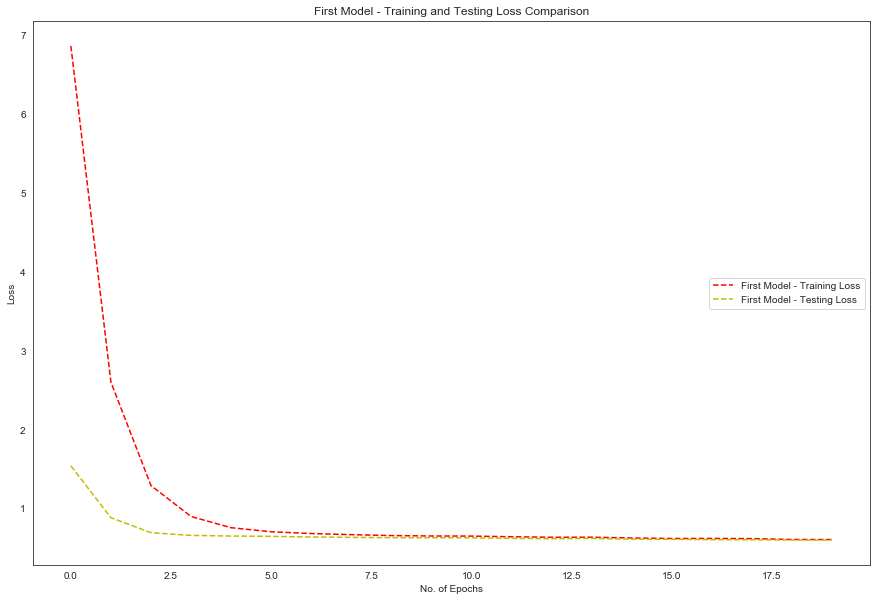

In [95]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each epoch of our first model

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot the first model training vs testing loss - we see them come together pretty quickly
plt.plot(first_model_loss, 'r--', label = "First Model - Training Loss")
plt.plot(first_model_val_loss, 'y--', label = "First Model - Testing Loss")

## Give some labels
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")

## Title and legend
plt.title("First Model - Training and Testing Loss Comparison")
plt.legend(loc = 'center right')

## Show the graph
plt.show()

## The first model converges pretty quickly on the loss function for both the training and testing data - right around the ninth or tenth iteration, they are almost the same.

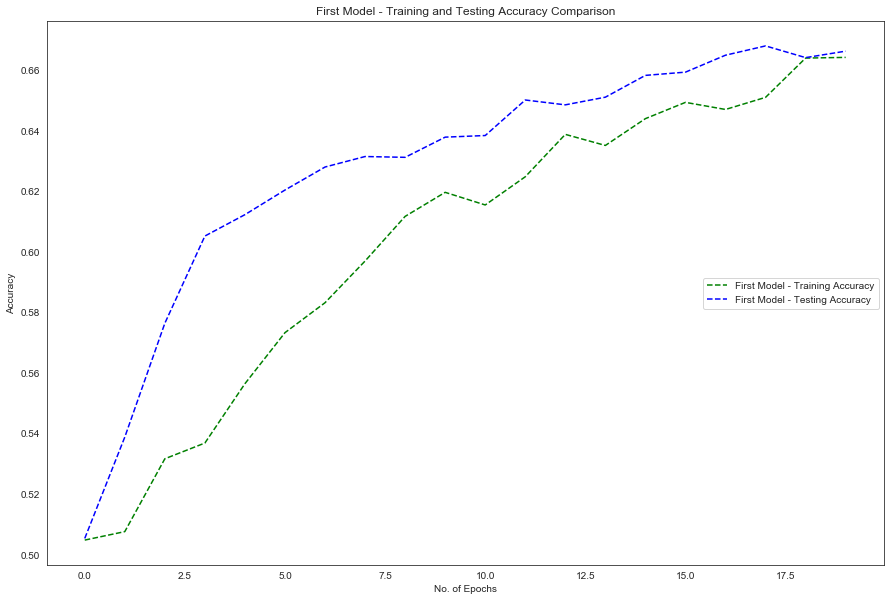

In [94]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each epoch of our first model

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot the first model training vs testing loss - we see them come together pretty quickly
plt.plot(first_model_acc, 'g--', label = "First Model - Training Accuracy")
plt.plot(first_model_val_acc, 'b--', label = "First Model - Testing Accuracy")

## Give some labels
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")

## Title and legend
plt.title("First Model - Training and Testing Accuracy Comparison")
plt.legend(loc = 'center right')

## Show the graph
plt.show()

## The first model has a slightly better testing accuracy throughout the different trials of the model.

## After twenty training trials, we see the acccuracy on the whole data set improve by 16%.  I will create another function for another model with another three layers.

## The strategy here is the deeper the network, the more the model can learn and adapt.  My goal is to do even better than the first model and to run faster.

## Here I will build another classifier and go through a similar process to find out how well it does.

In [79]:
##### Let's build another function to encapsulate all of the steps needed for this model

def create_dog_cat_image_classifier_two():
    
    
    ## Base model
    model = Sequential()
    
    ## First layer
    model.add(InputLayer(input_shape=[64, 64, 1]))

    model.add(Conv2D(filters = 32, kernel_size = 5, strides = 1, padding = "same", activation = "relu"))
    model.add(MaxPool2D(pool_size = 5, padding = "same"))
    
    ## Second layer

    model.add(Conv2D(filters = 64, kernel_size = 5, strides = 1, padding = "same", activation = "relu"))
    model.add(MaxPool2D(pool_size = 5, padding = "same"))
    
    ## Third layer

    model.add(Conv2D(filters = 32, kernel_size = 5, strides = 1, padding = "same", activation = "relu"))
    model.add(MaxPool2D(pool_size = 5, padding = "same"))
    
    ## Fourth layer
    
    model.add(Conv2D(filters = 64, kernel_size = 5, strides = 1, padding = "same", activation = "relu"))
    model.add(MaxPool2D(pool_size = 5, padding = "same"))
    
    ## Fifth layer
    
    model.add(Conv2D(filters = 32, kernel_size = 5, strides = 1, padding = "same", activation = "relu"))
    model.add(MaxPool2D(pool_size = 5, padding = "same"))
    
    ## Sixth layer
    
    model.add(Conv2D(filters = 64, kernel_size = 5, strides = 1, padding = "same", activation = "relu"))
    model.add(MaxPool2D(pool_size = 5, padding = "same"))
    
    ## Add dropout to solve for overfitting

    model.add(Dropout(0.25)) ## 25% of data gets sliced out
    model.add(Flatten())

    model.add(Dense(512, activation = "relu"))
    model.add(Dropout(rate = 0.5))

    ## Add layer for our prediction - cats or dogs?
    
    model.add(Dense(2, activation = "softmax"))

    ## Use Adam as our optimizer with a really low learning rate - this can probably be tweaked.
    optimizer = Adam(lr = 0.0001)
    
    ## Bring everything together
    model.compile(optimizer = optimizer, loss = "categorical_crossentropy", metrics = ["accuracy"])
    
    ## Return the completed model
    return model

In [80]:
## Create a new instance of our new model

second_dog_cat_model = create_dog_cat_image_classifier_two()

In [81]:
## Run the model through a similar process as above, using the training data and the testing data to validate 
## against.

second_dog_cat_model.fit(X_train, y_train, epochs = 20, batch_size = 1000,
                        validation_data = (X_test, y_test))

Train on 17500 samples, validate on 7500 samples
Epoch 1/20
17500/17500 [==============================] - 38s 2ms/sample - loss: 0.6927 - accuracy: 0.5018 - val_loss: 0.6919 - val_accuracy: 0.5492
Epoch 2/20
17500/17500 [==============================] - 37s 2ms/sample - loss: 0.6904 - accuracy: 0.5441 - val_loss: 0.6874 - val_accuracy: 0.5619
Epoch 3/20
17500/17500 [==============================] - 37s 2ms/sample - loss: 0.6824 - accuracy: 0.5867 - val_loss: 0.6730 - val_accuracy: 0.6061
Epoch 4/20
17500/17500 [==============================] - 37s 2ms/sample - loss: 0.6607 - accuracy: 0.6346 - val_loss: 0.6454 - val_accuracy: 0.6412
Epoch 5/20
17500/17500 [==============================] - 37s 2ms/sample - loss: 0.6359 - accuracy: 0.6489 - val_loss: 0.6407 - val_accuracy: 0.6291
Epoch 6/20
17500/17500 [==============================] - 37s 2ms/sample - loss: 0.6174 - accuracy: 0.6674 - val_loss: 0.6052 - val_accuracy: 0.6719
Epoch 7/20
17500/17500 [==============================] -

In [96]:
## Print a summary of the new model

second_dog_cat_model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_45 (Conv2D)           (None, 64, 64, 32)        832       
_________________________________________________________________
max_pooling2d_45 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_46 (Conv2D)           (None, 13, 13, 64)        51264     
_________________________________________________________________
max_pooling2d_46 (MaxPooling (None, 3, 3, 64)          0         
_________________________________________________________________
conv2d_47 (Conv2D)           (None, 3, 3, 32)          51232     
_________________________________________________________________
max_pooling2d_47 (MaxPooling (None, 1, 1, 32)          0         
_________________________________________________________________
conv2d_48 (Conv2D)           (None, 1, 1, 64)        

## Now let's visualize the performance for this model

In [97]:
## Create variables for each output from the second model to visualize performance

second_model_loss = second_dog_cat_model.history.history['loss']
second_model_val_loss = second_dog_cat_model.history.history['val_loss']

second_model_acc = second_dog_cat_model.history.history['accuracy']
second_model_val_acc = second_dog_cat_model.history.history['val_accuracy']

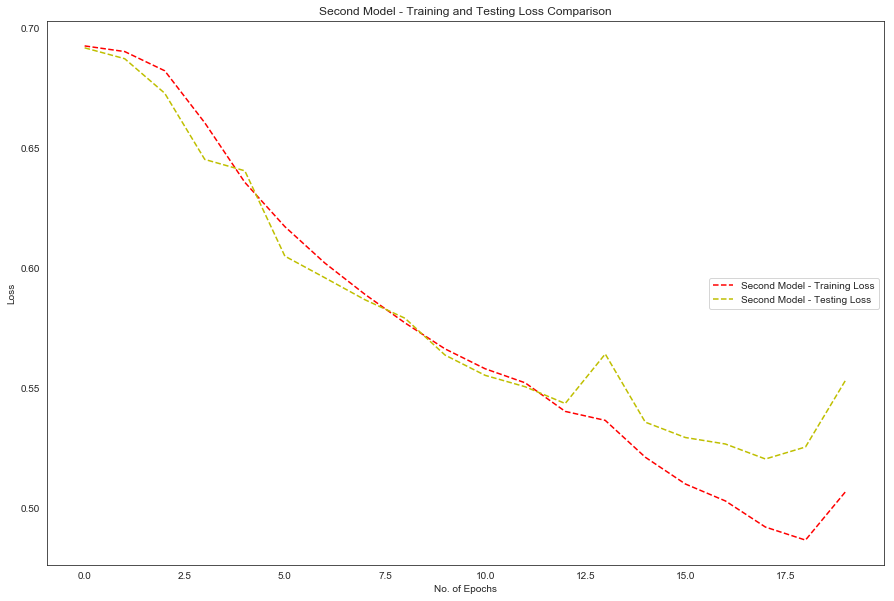

In [100]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each epoch of our second model

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot the second model training vs testing loss - these don't converge quite as quickly
plt.plot(second_model_loss, 'r--', label = "Second Model - Training Loss")
plt.plot(second_model_val_loss, 'y--', label = "Second Model - Testing Loss")

## Give some labels
plt.xlabel("No. of Epochs")
plt.ylabel("Loss")

## Title and legend
plt.title("Second Model - Training and Testing Loss Comparison")
plt.legend(loc = 'center right')

## Show the graph
plt.show()

## This model starts at a much lower loss value for both the training and validation (testing) data.  What does this tell me?  That already this model is going to outperform the first one.

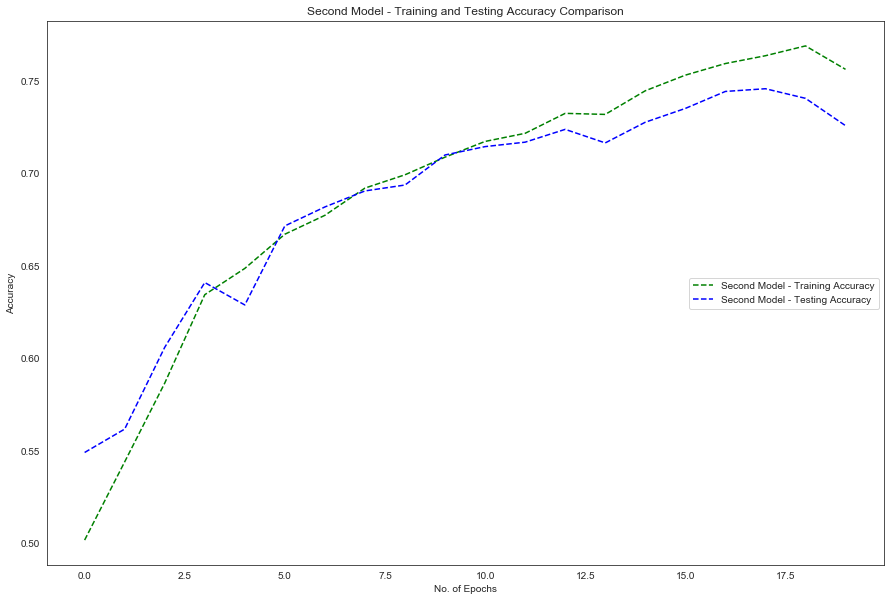

In [103]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each epoch of our first model

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot the second model training vs testing accuracy
plt.plot(second_model_acc, 'g--', label = "Second Model - Training Accuracy")
plt.plot(second_model_val_acc, 'b--', label = "Second Model - Testing Accuracy")

## Give some labels
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")

## Title and legend
plt.title("Second Model - Training and Testing Accuracy Comparison")
plt.legend(loc = 'center right')

## Show the graph
plt.show()

## We see the second model improving accuracy with just twenty training cycles, and it doesn't show any sign of "peaking" or leveling off.

## What happens if we keep this model and retrain it from this point, now that it has had some practice?  We should see accuracy scores get better, right?

In [131]:
second_model_retraining = second_dog_cat_model.fit(X_train, y_train, epochs = 20, batch_size = 1000,
                                    validation_data = (X_test, y_test))

Train on 17500 samples, validate on 7500 samples
Epoch 1/20
17500/17500 [==============================] - 43s 2ms/sample - loss: 0.4937 - accuracy: 0.7682 - val_loss: 0.5210 - val_accuracy: 0.7491
Epoch 2/20
17500/17500 [==============================] - 41s 2ms/sample - loss: 0.4724 - accuracy: 0.7826 - val_loss: 0.5064 - val_accuracy: 0.7557
Epoch 3/20
17500/17500 [==============================] - 40s 2ms/sample - loss: 0.4625 - accuracy: 0.7874 - val_loss: 0.5275 - val_accuracy: 0.7472
Epoch 4/20
17500/17500 [==============================] - 39s 2ms/sample - loss: 0.4619 - accuracy: 0.7866 - val_loss: 0.5105 - val_accuracy: 0.7567
Epoch 5/20
17500/17500 [==============================] - 39s 2ms/sample - loss: 0.4562 - accuracy: 0.7913 - val_loss: 0.5100 - val_accuracy: 0.7579
Epoch 6/20
17500/17500 [==============================] - 40s 2ms/sample - loss: 0.4481 - accuracy: 0.7955 - val_loss: 0.4999 - val_accuracy: 0.7608
Epoch 7/20
17500/17500 [==============================] -

## Let's see if the accuracy really does improve:

In [133]:
## Create variables for each output from the second model retraining to visualize performance

last_model_loss = second_model_retraining.history['loss']
last_model_val_loss = second_model_retraining.history['val_loss']

last_model_acc = second_model_retraining.history['accuracy']
last_model_val_acc = second_model_retraining.history['val_accuracy']

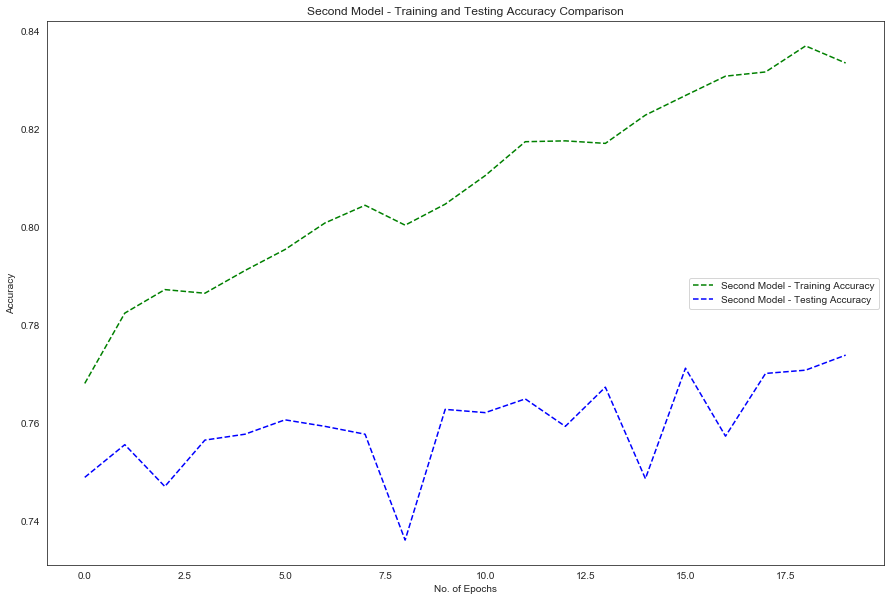

In [134]:
### Reset seaborn to the default background - for better viewing
sns.set_style("white")

## Plot scores on each epoch of our second model being retrained

## Set the figure size    
plt.figure(figsize= (15, 10))

## Plot the second model training vs testing accuracy
plt.plot(last_model_acc, 'g--', label = "Second Model - Training Accuracy")
plt.plot(last_model_val_acc, 'b--', label = "Second Model - Testing Accuracy")

## Give some labels
plt.xlabel("No. of Epochs")
plt.ylabel("Accuracy")

## Title and legend
plt.title("Second Model - Training and Testing Accuracy Comparison")
plt.legend(loc = 'center right')

## Show the graph
plt.show()

## We see that the model is not improving its testing accuracy, even though the training accuracy is still climbing.  This tells me that the model is pretty much peaked at this level of accuracy and that I should save the model as is, and start using it to make predictions.

In [138]:
## Save the model - we wouldn't want to lose all that training work for nothing!

tf.saved_model.save(second_dog_cat_model, "dog_cat_model")

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: dog_cat_model\assets


### Loading in my saved model to test the output.

In [15]:
## Load in the saved model - now we can use this to predict cats and dogs on the true test data.

second_dog_cat_model = tf.keras.models.load_model("dog_cat_model")

## Let's create a function to load in the test data now.  This one will look similar to the one above.

In [8]:
def create_test_data():
    
    ## Save all the testing information into an empty list
    testing_data = []
    
    ## Loop through every image listed in the training file
    for img in os.listdir(test_dir):
        
        ### Create a path for every image
        path = os.path.join(test_dir, img)
        
        ## Get the image number - these won't have labels so we just use the ID to identify them
        img_num = img.split(".")[0]
        
        ## Use cv2 module to read in the image
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) ## Transform to grey scale
        
        ## Resize the image to standard image size of 64x64, for similar reason as above, they come in diff. sizes
        img = cv2.resize(img, (img_size, img_size))
        
        ## Also missed the normalization step here but it seems to work pretty well
        
        ## Append each image and the ID to testing data
        testing_data.append([np.array(img), img_num])
        
    ## Randomize testing data so that models don't fall victim to overfitting
    shuffle(testing_data)
    
    ## This can be saved to a file to save on processing time or if running on different machines
    ## np.save("D:\\Stupid Cat Photos\\test_data_shuffled.npy", testing_data)
    
    return testing_data

In [9]:
## Using the pictures, we generate test data to actually evaluate the model

test_data = create_test_data()

In [10]:
## Perform similar transformations that were needed for the training data

## Resize the array to a format compatible with the data mining techniques
testing_X = np.array([i[0] for i in test_data]).reshape(-1, img_size, img_size, 1)

testing_y = [i[1] for i in test_data]

## Change the datatype to float - again, so that we can use these to make predictions
testing_X = testing_X.astype("float")

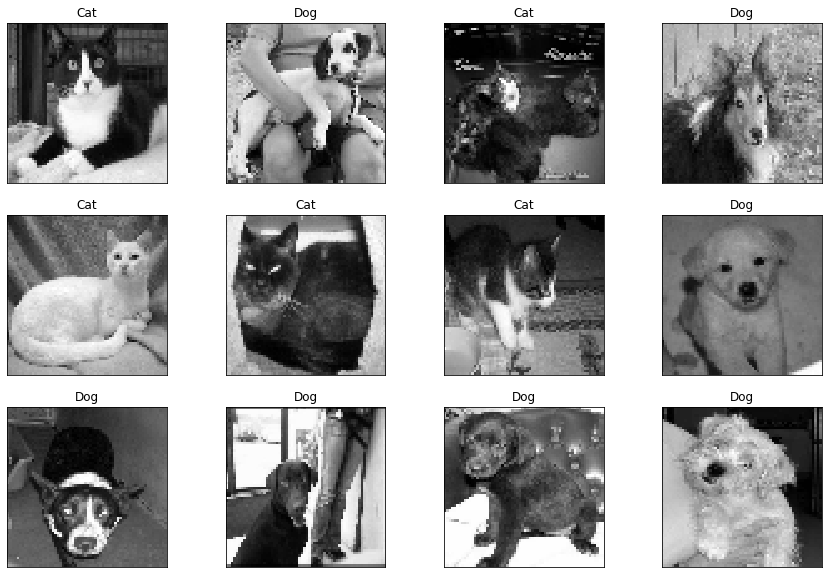

In [36]:
##### Let's see how our model does with actually classifying dogs and cats by plotting them out!

fig = plt.figure(figsize = (15, 10))

## Loop through the first 12 images in our test data
for num, data in enumerate(test_data[:12]):
    
    ## Get the image number
    img_num = data[1]
    ## Get the actual image data values we'll use to predict
    img_data = data[0]
    
    ## Create a plot for each individual image
    y = fig.add_subplot(3, 4, num+1)
    
    
    original = img_data
    
    ## Perform same transformation as above
    data = img_data.reshape(-1, img_size, img_size, 1)
    
    ## Change datatype to float
    data = data.astype("float")
    
    ## Spit out what our predicted value would be for the first twelve shuffled images
    model_out = second_dog_cat_model.predict(data)[0]
    
    ## If it is greater than .75, it is going to be labeled "Dog"
    if np.argmax(model_out) > .75: str_label = "Dog"
    
    ## Otherwise, "Cat"
    else: str_label = "Cat"
    
    y.imshow(original, cmap = "gray")
    
    ## Give the right label to the image
    plt.title(str_label)
    
    ## Remove grid lines
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)

## Show how well our model did - pretty great job!
plt.show()

In [32]:
## Generate a submission file - assigning the predicted outcomes to each image
## Let's see how we did!

## Generate a new CSV file, and include the id & label column headers
with open("submission_file.csv", "w") as f:
    f.write("id, label\n")

## Open the file again, and this time start adding predictions and the image ID numbers
with open("submission_file.csv", "a") as f:
    
    ## Loop through all of the test data
    for data in test_data:
        
        ## Image number
        img_num = data[1]
        
        ## Actual image data to perform predictions
        img_data = data[0]
        
        orig = img_data
        
        ## Reshape the array to match the dimensions needed for the predictor
        data = img_data.reshape(-1, img_size, img_size, 1)
        ## Change the data type to floating point values since we can't use integers
        data = data.astype("float")
        
        ## Spit out our predictions
        model_out = second_dog_cat_model.predict(data)[0]
        
        ## Write the output to our file.
        f.write('{}, {}\n'.format(img_num, model_out[1]))

## Here is my results based on the competition:

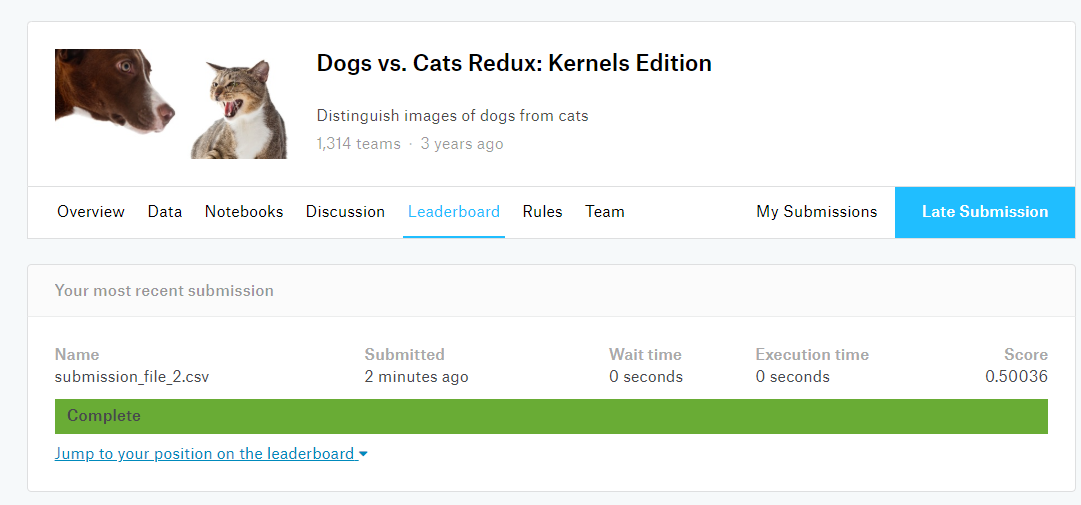

## Thanks for reading my analysis!